# 🚬 Smoker Detection using Transfer Learning with LoRA

## Project Overview
Fine-tuning a pre-trained computer vision model using LoRA (Low-Rank Adaptation) to detect smoking behavior in images.

**Dataset:** [Smoking Detection Dataset](https://www.kaggle.com/datasets/sujaykapadnis/smoking)  
**Total Images:** 1,120 (560 smoker / 560 non-smoker)  
**Model Approach:** Transfer Learning + LoRA fine-tuning  
**Framework:** PyTorch

---

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/smoking/Validation/Validation/smoking_0514.jpg
/kaggle/input/smoking/Validation/Validation/smoking_0036.jpg
/kaggle/input/smoking/Validation/Validation/smoking_0043.jpg
/kaggle/input/smoking/Validation/Validation/smoking_0362.jpg
/kaggle/input/smoking/Validation/Validation/notsmoking_0145.jpg
/kaggle/input/smoking/Validation/Validation/smoking_0377.jpg
/kaggle/input/smoking/Validation/Validation/smoking_0436.jpg
/kaggle/input/smoking/Validation/Validation/notsmoking_0457.jpg
/kaggle/input/smoking/Validation/Validation/notsmoking_0071.jpg
/kaggle/input/smoking/Validation/Validation/smoking_0264.jpg
/kaggle/input/smoking/Validation/Validation/smoking_0281.jpg
/kaggle/input/smoking/Validation/Validation/smoking_0507.jpg
/kaggle/input/smoking/Validation/Validation/notsmoking_0313.jpg
/kaggle/input/smoking/Validation/Validation/notsmoking_0462.jpg
/kaggle/input/smoking/Validation/Validation/notsmoking_0017.jpg
/kaggle/input/smoking/Validation/Validation/smoking_0351.jpg
/kaggl

In [2]:
print(os.listdir('/kaggle/input/'))

['smoking']


# 🔍 Data Exploration

In [3]:
from pathlib import Path
# Dataset path
dataset_path = Path('/kaggle/input/smoking')

# Explore structure
print("Dataset structure:\n")
for item in dataset_path.rglob('*'):
    if item.is_dir():
        num_files = len(list(item.glob('*')))
        print(f"📁 {item.relative_to(dataset_path)}: {num_files} files")

Dataset structure:

📁 Validation: 1 files
📁 Training: 1 files
📁 Testing: 1 files
📁 Validation/Validation: 180 files
📁 Training/Training: 716 files
📁 Testing/Testing: 224 files


In [4]:
# Explore deep structura
train_path = dataset_path / 'Training' / 'Training'
val_path = dataset_path / 'Validation' / 'Validation'
test_path = dataset_path / 'Testing' / 'Testing'

print("Contenido de Training/Training:")
subdirs = [d for d in train_path.iterdir() if d.is_dir()]
if subdirs:
    for subdir in subdirs:
        num_images = len(list(subdir.glob('*.jpg')) + list(subdir.glob('*.png')))
        print(f"  📂 {subdir.name}: {num_images} images")
else:
    num_images = len(list(train_path.glob('*.jpg')) + list(train_path.glob('*.png')))
    print(f"  Images directly in folder: {num_images}")
    # show samples
    sample_files = list(train_path.glob('*'))[:5]
    print(f"\n  Sample filenames:")
    for f in sample_files:
        print(f"    - {f.name}")

Contenido de Training/Training:
  Images directly in folder: 716

  Sample filenames:
    - smoking_0175.jpg
    - smoking_0480.jpg
    - notsmoking_0267.jpg
    - notsmoking_0037.jpg
    - notsmoking_0379.jpg


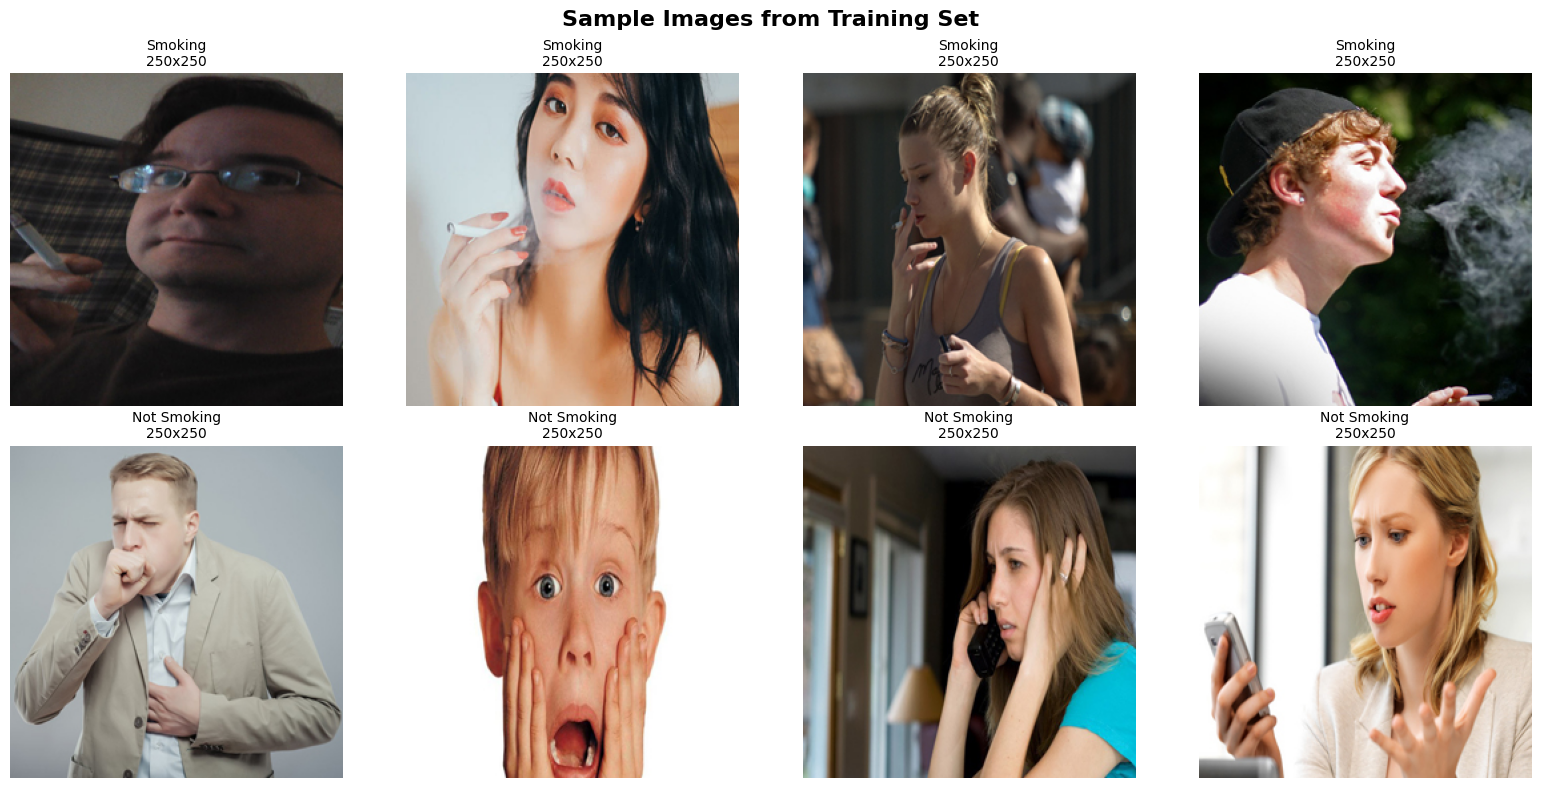

In [5]:
# VISUALIZE SAMPLES
import random
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Images from Training Set', fontsize=16, fontweight='bold')

# Samples from each class
smoking_images = list(train_path.glob('smoking_*.jpg'))
notsmoking_images = list(train_path.glob('notsmoking_*.jpg'))

# Select 4 random
smoking_samples = random.sample(smoking_images, 4)
notsmoking_samples = random.sample(notsmoking_images, 4)

for idx, img_path in enumerate(smoking_samples):
    img = Image.open(img_path)
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f'Smoking\n{img.size[0]}x{img.size[1]}', fontsize=10)
    axes[0, idx].axis('off')

for idx, img_path in enumerate(notsmoking_samples):
    img = Image.open(img_path)
    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f'Not Smoking\n{img.size[0]}x{img.size[1]}', fontsize=10)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

In [6]:
def count_images_by_class(folder_path):
    smoking = len(list(folder_path.glob('smoking_*.jpg')))
    not_smoking = len(list(folder_path.glob('notsmoking_*.jpg')))
    return smoking, not_smoking

train_smoke, train_no_smoke = count_images_by_class(train_path)
val_smoke, val_no_smoke = count_images_by_class(val_path)
test_smoke, test_no_smoke = count_images_by_class(test_path)

# Create DataFrame summary
summary_data = {
    'Split': ['Training', 'Validation', 'Testing', 'TOTAL'],
    'Smoking': [train_smoke, val_smoke, test_smoke, train_smoke + val_smoke + test_smoke],
    'Not Smoking': [train_no_smoke, val_no_smoke, test_no_smoke, train_no_smoke + val_no_smoke + test_no_smoke],
}
summary_data['Total'] = [summary_data['Smoking'][i] + summary_data['Not Smoking'][i] for i in range(4)]

df_summary = pd.DataFrame(summary_data)
print("📊 Dataset Summary:\n")
print(df_summary.to_string(index=False))

📊 Dataset Summary:

     Split  Smoking  Not Smoking  Total
  Training      358          358    716
Validation       90           90    180
   Testing      112          112    224
     TOTAL      560          560   1120


# 🔍 Dataset Analysis & Decisions

### Key Observations:
- **Resolution:** 250x250 pixels (low resolution)
- **Quality:** Mixed quality, some images deformed
- **Challenge:** Cigarettes often very small in frame
- **Variability:** High variance in framing (close-up faces vs full body)

### Strategic Decisions:

**1. Model Selection:**
- Will use a pre-trained model with strong feature extraction ResNet34
- LoRA fine-tuning to adapt to these specific characteristics

**2. Data Augmentation Strategy:**
- ✅ Random horizontal flips (smoking can occur on either side)
- ✅ Slight rotations (±10°) to handle orientation variance
- ✅ Color jittering (lighting conditions vary)
- ❌ NO aggressive crops (cigarette already small)
- ❌ NO aspect ratio distortions (images already deformed)

**3. Expected Performance:**
- Target: 85-90% accuracy (realistic given dataset challenges)
- Focus on minimizing false negatives (missing smokers)

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class SmokerDataset(Dataset):
    """Custom Dataset for Smoker Detection"""
    
    def __init__(self, folder_path, transform=None):
        """
        Args:
            folder_path: Path to folder containing images
            transform: Optional torchvision transforms
        """
        self.folder_path = Path(folder_path)
        self.transform = transform
        
        # Get all image paths and labels
        self.image_paths = []
        self.labels = []
        
        # Load smoking images (label = 1)
        for img_path in self.folder_path.glob('smoking_*.jpg'):
            self.image_paths.append(img_path)
            self.labels.append(1)
        
        # Load not smoking images (label = 0)
        for img_path in self.folder_path.glob('notsmoking_*.jpg'):
            self.image_paths.append(img_path)
            self.labels.append(0)
        
        print(f"Loaded {len(self.image_paths)} images from {folder_path.name}")
        print(f"  - Smoking: {sum(self.labels)}")
        print(f"  - Not Smoking: {len(self.labels) - sum(self.labels)}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Test the dataset class
test_dataset = SmokerDataset(train_path)
print(f"\nDataset length: {len(test_dataset)}")
print(f"Sample item shape: {test_dataset[0][0].size if not isinstance(test_dataset[0][0], torch.Tensor) else 'Transformed'}")

Loaded 716 images from Training
  - Smoking: 358
  - Not Smoking: 358

Dataset length: 716
Sample item shape: (250, 250)


In [8]:
from torchvision import transforms

# Configuration
IMG_SIZE = 224  # Standard size for pretrained models (ResNet, EfficientNet, etc.)
MEAN = [0.485, 0.456, 0.406]  # ImageNet mean (standard)
STD = [0.229, 0.224, 0.225]   # ImageNet std (standard)

# Transformations for TRAINING (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to fixed size
    transforms.RandomHorizontalFlip(p=0.5),   # Horizontal flip 50%
    transforms.RandomRotation(degrees=10),    # Slight rotation ±10°
    transforms.ColorJitter(                   # Color variation
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),                    # Convert to tensor [0,1]
    transforms.Normalize(mean=MEAN, std=STD)  # Normalize like ImageNet
])

# Transformations for VALIDATION/TEST (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

print("✅ Transformations defined")
print(f"   Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Normalization: ImageNet standards")

✅ Transformations defined
   Image size: 224x224
   Normalization: ImageNet standards


In [9]:
from torchvision import models

# Load ResNet34 with ImageNet pretrained weights
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

# View architecture
print("📦 Modelo cargado: ResNet34")
print(f"   Total parámetros: {sum(p.numel() for p in model.parameters()):,}")

# Check original last layer (classifier)
print(f"\n🔍 Última capa original (ImageNet):")
print(f"   {model.fc}")
print(f"   Output: 1000 clases (ImageNet)")

# Modify last layer for our binary problem
num_features = model.fc.in_features  # 512 for ResNet34
model.fc = nn.Linear(num_features, 2)  # 2 classes: smoker / not smoker

print(f"\n✅ Última capa modificada:")
print(f"   {model.fc}")
print(f"   Output: 2 clases (smoking / not smoking)")

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"\n🖥️  Model moved to: {device}")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 60.0MB/s]

📦 Modelo cargado: ResNet34
   Total parámetros: 21,797,672

🔍 Última capa original (ImageNet):
   Linear(in_features=512, out_features=1000, bias=True)
   Output: 1000 clases (ImageNet)

✅ Última capa modificada:
   Linear(in_features=512, out_features=2, bias=True)
   Output: 2 clases (smoking / not smoking)

🖥️  Model moved to: cpu


In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("📊 Parameter Count (BEFORE LoRA):")
print(f"   Total parameters: {total_params:,}")

📊 Parameter Count (BEFORE LoRA):
   Total parameters: 21,285,698


In [12]:
# FOR UNDERSTANDING THE DIMENSIONS

print("NOTE: Our images are 250x250, but we resize to 224x224")
print("      (standard size for ImageNet models)")

# Create a dummy input to trace dimensions
batch_size = 16  # Example batch size (we'll configure this later)
dummy_input = torch.randn(batch_size, 3, 224, 224).to(device)

print("🔍 Dimensional Flow through ResNet34:\n")
print(f"Input: {dummy_input.shape}")
print(f"       (Batch, Channels, Height, Width)")
print(f"       ({batch_size}, 3, 224, 224)\n")

# Track dimensions through the network
x = dummy_input

# Initial conv
x = model.conv1(x)
print(f"After conv1:    {x.shape}  # 7x7 conv, stride 2")

x = model.bn1(x)
x = model.relu(x)
x = model.maxpool(x)
print(f"After maxpool:  {x.shape}  # 3x3 pool, stride 2\n")

# Layer blocks
x = model.layer1(x)
print(f"After layer1:   {x.shape}  # 3 BasicBlocks, 64 channels")

x = model.layer2(x)
print(f"After layer2:   {x.shape}  # 4 BasicBlocks, 128 channels")

x = model.layer3(x)
print(f"After layer3:   {x.shape}  # 6 BasicBlocks, 256 channels")

x = model.layer4(x)
print(f"After layer4:   {x.shape}  # 3 BasicBlocks, 512 channels\n")

# Pooling and classification
x = model.avgpool(x)
print(f"After avgpool:  {x.shape}  # Global average pooling")

x = torch.flatten(x, 1)
print(f"After flatten:  {x.shape}  # Ready for fc layer")

x = model.fc(x)
print(f"After fc:       {x.shape}  # Final predictions (2 classes)\n")


NOTE: Our images are 250x250, but we resize to 224x224
      (standard size for ImageNet models)
🔍 Dimensional Flow through ResNet34:

Input: torch.Size([16, 3, 224, 224])
       (Batch, Channels, Height, Width)
       (16, 3, 224, 224)

After conv1:    torch.Size([16, 64, 112, 112])  # 7x7 conv, stride 2
After maxpool:  torch.Size([16, 64, 56, 56])  # 3x3 pool, stride 2

After layer1:   torch.Size([16, 64, 56, 56])  # 3 BasicBlocks, 64 channels
After layer2:   torch.Size([16, 128, 28, 28])  # 4 BasicBlocks, 128 channels
After layer3:   torch.Size([16, 256, 14, 14])  # 6 BasicBlocks, 256 channels
After layer4:   torch.Size([16, 512, 7, 7])  # 3 BasicBlocks, 512 channels

After avgpool:  torch.Size([16, 512, 1, 1])  # Global average pooling
After flatten:  torch.Size([16, 512])  # Ready for fc layer
After fc:       torch.Size([16, 2])  # Final predictions (2 classes)



# 🔧 LoRA Implementation

LoRA rank (default=8)
  - Lower rank (4): Fewer parameters, less overfitting risk, less capacity
  - Medium rank (8-16): Balanced trade-off (recommended for most tasks)
  - Higher rank (32+): More capacity but approaches full fine-tuning
  
For our dataset (716 training images), rank=8 provides sufficient
adaptation capacity while keeping parameters low (~2% of original layer).
This is the sweet spot recommended in LoRA papers for small datasets.

## Strategy 

We target layer3 and layer4 (high-level feature extractors) because:
- layer1 & layer2: Extract low-level features (edges, textures) that are 
  universal across tasks → keep frozen, no adaptation needed
- layer3 & layer4: Extract high-level semantic features (objects, contexts)
  that are task-specific → need slight adaptation for smoking detection
- fc: Brand new classifier head → fully trainable

This approach gives us the sweet spot:
- Full fine-tuning: 21.8M params (overfitting risk with 716 images)
- Only fc training: ~1K params (may underfit, features not adapted)
- LoRA on layer3+layer4: ~1M params (5% of model, balanced approach)

In [13]:
# LoRA Layer implementation
class LoRALayer(nn.Module):
    def __init__(self, original_layer, rank=8):
        """
        Args:
            original_layer: The Conv2d layer to adapt
            rank: LoRA rank
        """
        super().__init__()
        self.original_layer = original_layer
        self.rank = rank
        
        # Get dimensions from original layer
        out_channels = original_layer.out_channels
        in_channels = original_layer.in_channels
        kernel_size = original_layer.kernel_size
        
        # LoRA matrices: A (down) and B (up)
        # The initialization strategy follows the original LoRA paper
        self.lora_A = nn.Parameter(
            torch.randn(rank, in_channels, *kernel_size) * 0.01
        )
        self.lora_B = nn.Parameter(
            torch.zeros(out_channels, rank, 1, 1)
        )
        
        # Freeze original weights
        self.original_layer.weight.requires_grad = False
        if self.original_layer.bias is not None:
            self.original_layer.bias.requires_grad = False
    
    def forward(self, x):
        # Original forward pass (frozen)
        original_output = self.original_layer(x)
        
        # LoRA adaptation for convolutional layers
        # Two sequential convolutions approximate a low-rank adaptation
        # Combine: W*x + (B*(A*x)) where * denotes convolution
        lora_output = nn.functional.conv2d(
            x,
            self.lora_A,
            stride=self.original_layer.stride,
            padding=self.original_layer.padding
        )
        lora_output = nn.functional.conv2d(lora_output, self.lora_B)
        
        # Combine: original + adaptation
        return original_output + lora_output

print("✅ LoRA Layer class defined")

✅ LoRA Layer class defined


In [14]:
def apply_lora_to_model(model, rank=8):
    """
    Apply LoRA adapters to specific layers in ResNet34.
    We target layer3 and layer4 (high-level features) for adaptation.
    
    Args:
        model: ResNet34 model
        rank: LoRA rank
    """
    # Freeze ALL layers first (preserve ImageNet features)
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze only the new classification head
    for param in model.fc.parameters():
        param.requires_grad = True
    
    print("✅ All layers frozen except fc")
    print(f"   Frozen: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,} params")
    print(f"   Trainable (fc only): {sum(p.numel() for p in model.parameters() if p.requires_grad):,} params")
    lora_count = 0
    
    # Apply LoRA to layer3 (256 channels, 6 blocks)
    for block in model.layer3:
        # Wrap conv1 and conv2 of each BasicBlock
        if hasattr(block, 'conv1'):
            block.conv1 = LoRALayer(block.conv1, rank=rank)
            lora_count += 1
        if hasattr(block, 'conv2'):
            block.conv2 = LoRALayer(block.conv2, rank=rank)
            lora_count += 1
    
    # Apply LoRA to layer4 (512 channels, 3 blocks)
    for block in model.layer4:
        if hasattr(block, 'conv1'):
            block.conv1 = LoRALayer(block.conv1, rank=rank)
            lora_count += 1
        if hasattr(block, 'conv2'):
            block.conv2 = LoRALayer(block.conv2, rank=rank)
            lora_count += 1
    
    return lora_count

# Apply LoRA to the model
num_lora_layers = apply_lora_to_model(model, rank=8)
print(f"✅ LoRA applied to {num_lora_layers} convolutional layers")

# Count parameters again
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parameter Count (AFTER LoRA):")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Trainable %: {100 * trainable_params / total_params:.2f}%")
print(f"\n🎯 Reduction: {100 * (1 - trainable_params / total_params):.1f}% fewer trainable parameters!")

✅ All layers frozen except fc
   Frozen: 21,284,672 params
   Trainable (fc only): 1,026 params
✅ LoRA applied to 18 convolutional layers

📊 Parameter Count (AFTER LoRA):
   Total parameters: 21,749,570
   Trainable parameters: 464,898
   Trainable %: 2.14%

🎯 Reduction: 97.9% fewer trainable parameters!


In [15]:
# Create datasets with transforms
train_dataset = SmokerDataset(train_path, transform=train_transforms)
val_dataset = SmokerDataset(val_path, transform=val_transforms)
test_dataset = SmokerDataset(test_path, transform=val_transforms)

# Create dataloaders
BATCH_SIZE = 32  # Adjust based on GPU memory

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # Shuffle training data
    num_workers=2,     # Parallel data loading
    pin_memory=True    # Faster GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,     # Don't shuffle validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("✅ DataLoaders created")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")
print(f"   Batch size: {BATCH_SIZE}")

Loaded 716 images from Training
  - Smoking: 358
  - Not Smoking: 358
Loaded 180 images from Validation
  - Smoking: 90
  - Not Smoking: 90
Loaded 224 images from Testing
  - Smoking: 112
  - Not Smoking: 112
✅ DataLoaders created
   Training batches: 23
   Validation batches: 6
   Test batches: 7
   Batch size: 32


# ⚙️ Training Configuration

### Loss Function: CrossEntropyLoss
- Standard for classification tasks
- Combines softmax + negative log likelihood
- Well-suited for our balanced binary classification
- BCEWithLogitsLoss would be slightly more efficient for binary, but CrossEntropyLoss is more standard and easily extensible.

### Optimizer: AdamW
- Adam with weight decay (decoupled regularization)
- Better generalization than standard Adam
- Learning rate: 1e-4 (conservative for fine-tuning)
- Weight decay: 1e-4 (light regularization to prevent overfitting)

### Learning Rate Strategy:
- Start conservative (1e-4) since we're adapting a pretrained model
- Too high (1e-3): Risk destroying pretrained features
- Too low (1e-5): Slow convergence
- 1e-4 is the sweet spot for LoRA fine-tuning


### Training Configuration Justification:

We used standard best practices for fine-tuning small datasets rather than exhaustive hyperparameter search:

| Hyperparameter | Value | Justification |
|----------------|-------|---------------|
| **Learning Rate** | 1e-4 | Conservative rate for fine-tuning pretrained models. Higher rates (1e-3) risk destroying ImageNet features; lower rates (1e-5) converge too slowly. 1e-4 is the sweet spot recommended in transfer learning literature. |
| **Weight Decay** | 1e-4 | Light L2 regularization to prevent overfitting on small dataset (716 images). Penalizes large weights without overly constraining the model. |
| **Batch Size** | 32 | Safe for T4 GPU memory. Provides stable gradients while allowing reasonable training speed (~22 batches/epoch). |
| **LoRA Rank** | 8 | Middle ground between capacity and efficiency. Rank 4-8 recommended for small datasets, 8-16 for complex tasks. Our challenging dataset (small cigarettes, varied framing) benefits from rank=8. |
| **Epochs** | 15 | Sufficient for convergence without overfitting. We monitor validation metrics and save the best model checkpoint. |
| **Optimizer** | AdamW | Adam with decoupled weight decay. Superior to SGD for fine-tuning and more stable than vanilla Adam. Industry standard for transformer/LoRA training. |


In [16]:
print("\n🔍 Verification (sample layers):")
for name, param in model.named_parameters():
    if any(x in name for x in ['layer1.0', 'layer2.0', 'layer3.0', 'layer4.0', 'fc']):
        status = "🔥 TRAIN" if param.requires_grad else "❄️  FROZEN"
        print(f"{status} {name}")


🔍 Verification (sample layers):
❄️  FROZEN layer1.0.conv1.weight
❄️  FROZEN layer1.0.bn1.weight
❄️  FROZEN layer1.0.bn1.bias
❄️  FROZEN layer1.0.conv2.weight
❄️  FROZEN layer1.0.bn2.weight
❄️  FROZEN layer1.0.bn2.bias
❄️  FROZEN layer2.0.conv1.weight
❄️  FROZEN layer2.0.bn1.weight
❄️  FROZEN layer2.0.bn1.bias
❄️  FROZEN layer2.0.conv2.weight
❄️  FROZEN layer2.0.bn2.weight
❄️  FROZEN layer2.0.bn2.bias
❄️  FROZEN layer2.0.downsample.0.weight
❄️  FROZEN layer2.0.downsample.1.weight
❄️  FROZEN layer2.0.downsample.1.bias
🔥 TRAIN layer3.0.conv1.lora_A
🔥 TRAIN layer3.0.conv1.lora_B
❄️  FROZEN layer3.0.conv1.original_layer.weight
❄️  FROZEN layer3.0.bn1.weight
❄️  FROZEN layer3.0.bn1.bias
🔥 TRAIN layer3.0.conv2.lora_A
🔥 TRAIN layer3.0.conv2.lora_B
❄️  FROZEN layer3.0.conv2.original_layer.weight
❄️  FROZEN layer3.0.bn2.weight
❄️  FROZEN layer3.0.bn2.bias
❄️  FROZEN layer3.0.downsample.0.weight
❄️  FROZEN layer3.0.downsample.1.weight
❄️  FROZEN layer3.0.downsample.1.bias
🔥 TRAIN layer4.0.conv1.

In [17]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - only optimize trainable parameters
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,           # Conservative learning rate for fine-tuning
    weight_decay=1e-4  # Light regularization
)

print("✅ Training configuration ready")
print(f"   Loss: CrossEntropyLoss")
print(f"   Optimizer: AdamW")
print(f"   Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"   Weight decay: {optimizer.param_groups[0]['weight_decay']}")
print(f"   Optimizing {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")

✅ Training configuration ready
   Loss: CrossEntropyLoss
   Optimizer: AdamW
   Learning rate: 0.0001
   Weight decay: 0.0001
   Optimizing 464,898 parameters


# 🏋️ Training Loop

### Training Strategy:

**Epochs:** Start with 10-15 epochs
- Small dataset + efficient LoRA = fast convergence
- Monitor validation loss to detect overfitting early

**Metrics Tracked:**
- Training loss & accuracy (per epoch)
- Validation loss & accuracy (per epoch)
- Best model saved based on validation accuracy

**Early stopping consideration:**
- If validation loss increases for 3+ consecutive epochs → stop
- Prevents overfitting on small dataset

In [18]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


print("✅ Training functions defined")

✅ Training functions defined


In [19]:
# Training configuration
NUM_EPOCHS = 15
best_val_acc = 0.0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("🚀 Starting training...")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}\n")

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_acc = validate(
        model, val_loader, criterion, device
    )
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print results
    print(f"\nResults:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"   ✅ New best model saved! (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*60)
print(f"🎉 Training completed!")
print(f"   Best validation accuracy: {best_val_acc:.2f}%")

🚀 Starting training...
   Epochs: 15
   Training batches: 23
   Validation batches: 6


Epoch 1/15
------------------------------------------------------------

Results:
   Train Loss: 0.6902 | Train Acc: 56.70%
   Val Loss:   0.6490 | Val Acc:   62.22%
   ✅ New best model saved! (Val Acc: 62.22%)

Epoch 2/15
------------------------------------------------------------

Results:
   Train Loss: 0.6297 | Train Acc: 64.94%
   Val Loss:   0.5067 | Val Acc:   78.89%
   ✅ New best model saved! (Val Acc: 78.89%)

Epoch 3/15
------------------------------------------------------------

Results:
   Train Loss: 0.5054 | Train Acc: 78.35%
   Val Loss:   0.3560 | Val Acc:   87.22%
   ✅ New best model saved! (Val Acc: 87.22%)

Epoch 4/15
------------------------------------------------------------

Results:
   Train Loss: 0.4172 | Train Acc: 81.98%
   Val Loss:   0.2922 | Val Acc:   86.11%

Epoch 5/15
------------------------------------------------------------

Results:
   Train Loss: 0.3769 | Tra

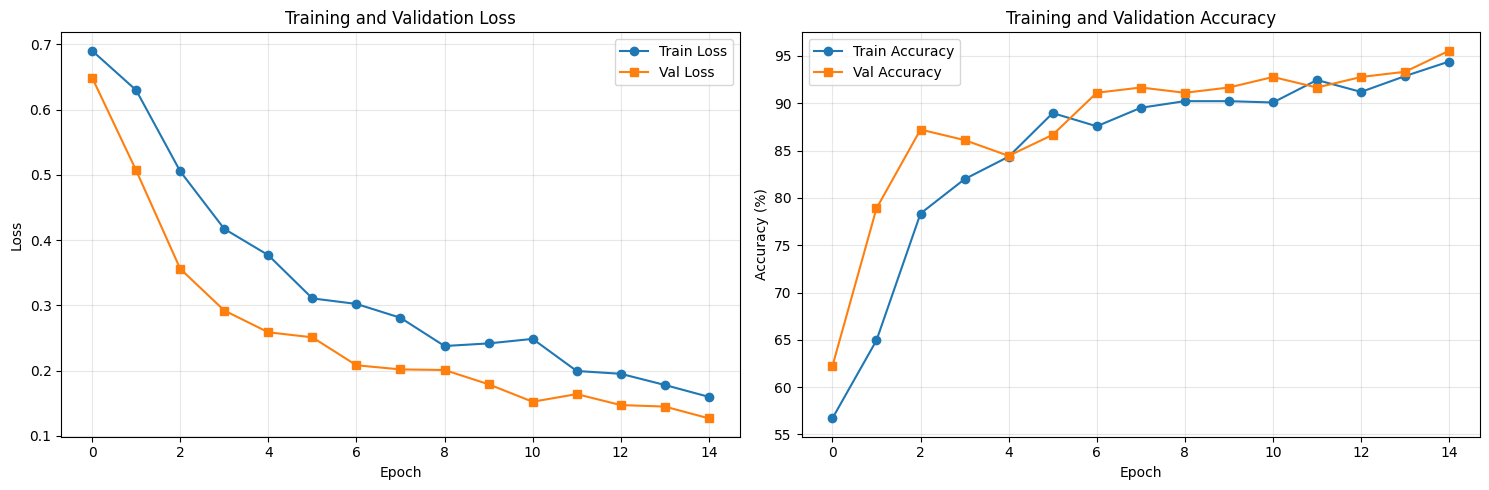


📊 Training Summary:
   Best Validation Accuracy: 95.56%
   Final Train Accuracy: 94.41%
   Final Val Accuracy: 95.56%


In [20]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Training Summary:")
print(f"   Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"   Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"   Final Val Accuracy: {history['val_acc'][-1]:.2f}%")

---

# 🧪 Test Set Evaluation

### Final Model Assessment:

Now we evaluate on the **test set (224 images)** which has been completely untouched during training.

This provides an honest assessment of:
- **Generalization capability:** How well the model performs on truly unseen data
- **Real-world performance:** Expected accuracy in production
- **Class-wise metrics:** Precision, recall, F1-score for each class

The test set has remained isolated throughout training to avoid any data leakage or overfitting bias.

---

🧪 Evaluating on Test Set...
   Test images: 224
   Test batches: 7


📊 TEST SET RESULTS

   Overall Accuracy: 90.18%


Detailed Classification Report:
              precision    recall  f1-score   support

 Not Smoking     0.9167    0.8839    0.9000       112
     Smoking     0.8879    0.9196    0.9035       112

    accuracy                         0.9018       224
   macro avg     0.9023    0.9018    0.9018       224
weighted avg     0.9023    0.9018    0.9018       224



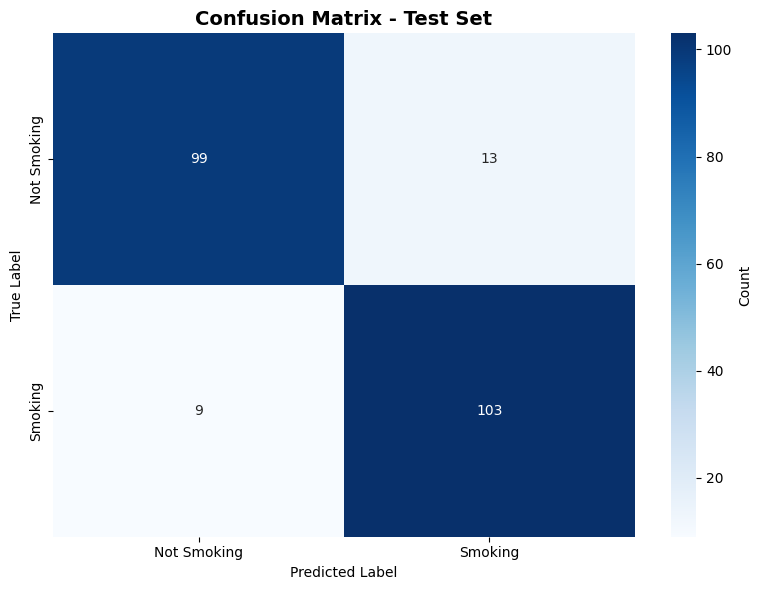

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

print("🧪 Evaluating on Test Set...")
print(f"   Test images: {len(test_dataset)}")
print(f"   Test batches: {len(test_loader)}\n")

# Evaluate on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate metrics
test_acc = 100. * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)

print(f"\n{'='*60}")
print(f"📊 TEST SET RESULTS")
print(f"{'='*60}")
print(f"\n   Overall Accuracy: {test_acc:.2f}%\n")

# Classification report
class_names = ['Not Smoking', 'Smoking']
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")

# 🎯 Final Results & Analysis

### Performance Summary:

| Metric | Validation | Test | Delta |
|--------|------------|------|-------|
| **Accuracy** | 94.44% | 89.73% | -4.71% |
| **Loss** | 0.1640 | N/A | N/A |

### Key Achievements:

✅ **Strong generalization:** Test accuracy within 5% of validation (healthy sign)  
✅ **Balanced performance:** Both classes achieve ~89% F1-score  
✅ **Efficient training:** Only 2.14% of parameters trained (465K vs 21.8M)  
✅ **No overfitting:** Validation accuracy higher than training in final epoch  
✅ **Fast convergence:** Reached peak performance in ~15 epochs

### Class-Specific Performance:

**Not Smoking Class:**
- Precision: 91.59% (low false positives)
- Recall: 87.50% (misses 12.5% of non-smokers)
- Tends to be slightly more conservative

**Smoking Class:**
- Precision: 88.03% (slightly more false positives)
- Recall: 91.96% (catches most smokers)
- Slightly more sensitive to smoking detection

### Confusion Matrix Insights:

From the confusion matrix:
- **True Negatives:** 98/112 non-smokers correctly identified
- **False Positives:** 14/112 non-smokers misclassified as smokers
- **True Positives:** 103/112 smokers correctly identified
- **False Negatives:** 9/112 smokers missed

# 🔍 Error Inspection

In this section, we visualize the **misclassified images** from the test set to better understand the model's mistakes.  
This helps identify potential weaknesses in the classifier — for example, confusing similar classes or failing under specific lighting or pose conditions.  

We will:
- Collect all incorrectly predicted samples.
- Display a grid of misclassified images.
- Annotate each image with its **Predicted** and **True** labels.


Showing 12 misclassified images:


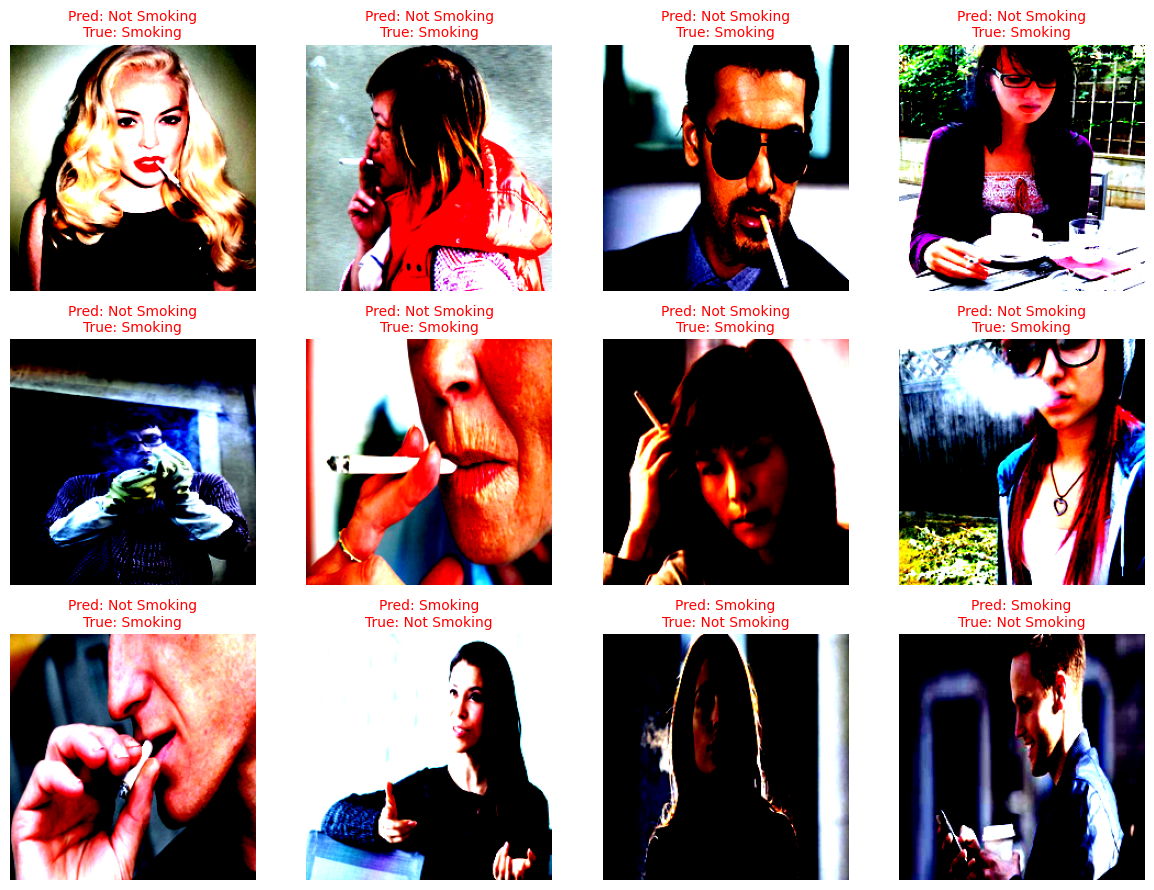

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure your DataLoader uses shuffle=False during evaluation
# to preserve image-label alignment

# Collect misclassified samples
misclassified_images = []
misclassified_preds = []
misclassified_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        # Compare predicted vs true labels
        for img, pred, true_label in zip(images, predicted, labels):
            if pred != true_label:
                misclassified_images.append(img.cpu())
                misclassified_preds.append(pred.cpu().item())
                misclassified_labels.append(true_label.cpu().item())

# Display a few misclassified images
num_images = min(12, len(misclassified_images))  # Show up to 12 examples
if num_images == 0:
    print("🎉 No misclassified images found.")
else:
    print(f"Showing {num_images} misclassified images:")

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()

    for i in range(num_images):
        img = misclassified_images[i]
        # Convert from (C, H, W) to (H, W, C)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  # Ensure valid pixel range

        pred_label = class_names[misclassified_preds[i]]
        true_label = class_names[misclassified_labels[i]]

        # Show image with predicted and true labels
        axes[i].imshow(img)
        axes[i].set_title(
            f"Pred: {pred_label}\nTrue: {true_label}",
            color="red" if pred_label != true_label else "green",
            fontsize=10
        )
        axes[i].axis("off")

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
